In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, train_test_split,GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
import json
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

***Import & Analize Data***

In [10]:
#Import data from json file and create a list

data = []
with open('/home/borjaregueral/Digital_Music_5.json') as f:
    for line in f:
        data.append(json.loads(line))

#Create a dataframe with the columns that are interesting for this exercise
#Columns left out: 'helpful', 'reviewTime', 'reviewerID','reviewerName'
names = ["overall", "reviewText"]
amazonraw = pd.DataFrame(data, columns=names)
amazonraw['overall'] = amazonraw['overall'].astype(int)
amazonraw.head()

,overall,reviewText
0,5,"It's hard to believe ""Memory of Trees"" came ou..."
1,5,"A clasically-styled and introverted album, Mem..."
2,5,I never thought Enya would reach the sublime h...
3,5,This is the third review of an irish album I w...
4,4,"Enya, despite being a successful recording art..."


In [11]:
#Analyse the dataset: types, length of the dataframe and NaN
amazonraw.info()
amazonraw.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 2 columns):
overall       64706 non-null int64
reviewText    64706 non-null object
dtypes: int64(1), object(1)
memory usage: 1011.1+ KB


overall        int64
reviewText    object
dtype: object

***Build Sentiment Scores and Categories***

In [12]:
amazonraw.overall.describe()

count    64706.000000
mean         4.222514
std          1.086081
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [13]:
#Change the Overall variable into a categorical variable
#Ratings equal or lower than 3 have been considered negative as the mean is 4.25.
#The hypothesis is that although the abovmentioned ratings could be considered positive they are negative

amazonraw.loc[amazonraw['overall'] <= 3, 'Sentiment'] = 0
amazonraw.loc[amazonraw['overall'] >=4 , 'Sentiment'] = 1
amazonraw.loc[amazonraw['Sentiment'] == 0, 'Category'] ='Negative'
amazonraw.loc[amazonraw['Sentiment'] == 1, 'Category'] = 'Positive'

In [14]:
#Count the each of the categories

a = amazonraw['Category'].value_counts('Positive')
b = pd.value_counts(amazonraw['Category'].values, sort=False)

print('Number of ocurrencies:\n', b)
print('\n')
print('Frequency of each value:\n', a)

Number of ocurrencies:
 Negative    12590
Positive    52116
dtype: int64


Frequency of each value:
 Positive    0.805428
Negative    0.194572
Name: Category, dtype: float64


In [15]:
#Downsample majority class (due to computational restrictions we downsample the majority instead of upsampling the minority)

# Separate majority and minority classes
amazon_majority = amazonraw[amazonraw.Sentiment == 1]
amazon_minority = amazonraw[amazonraw.Sentiment == 0]
 
# Downsample mairlinesass
amazon_majority_downsampled = resample(amazon_majority, replace=False, n_samples=12590, random_state=123) 
 
# Combine minority class with downsampled majority class
amazon = pd.concat([amazon_majority_downsampled, amazon_minority])
 
# Display new class counts
amazon.Category.value_counts()

Positive    12590
Negative    12590
Name: Category, dtype: int64

Text(0.5,1,'Categories in the downsampled dataset')

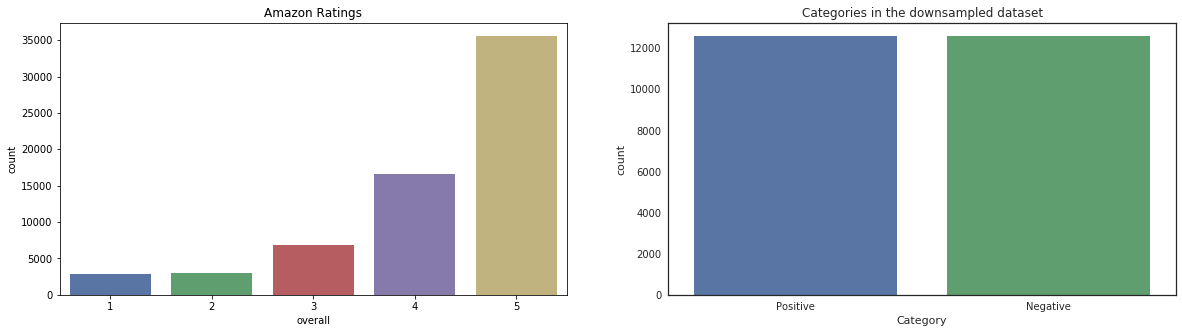

In [16]:
#Graphical representation of the positive and negative reviews

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)

sns.set(style="white")
ax = sns.countplot(x="overall", data=amazonraw)
plt.title('Amazon Ratings')

plt.subplot(1, 2, 2)
sns.set(style="white")
ax = sns.countplot(x="Category", data=amazon)
plt.title('Categories in the downsampled dataset')

In [17]:
#Create new dataframe that has the Categories, Overall scores, Sentiment and ReviewText
names = ['Category',"overall",'Sentiment', "reviewText"]
amazon1 = pd.DataFrame(amazon, columns=names)
amazon.head()

,overall,reviewText,Sentiment,Category
59643,5,This is a great song that will stand the test ...,1.0,Positive
55386,5,I am ashamed to say that such a high rating on...,1.0,Positive
29299,4,"Mobb deep have never disapointed fans , with a...",1.0,Positive
61457,4,I first learned of Sharon Van Etten when Rolli...,1.0,Positive
41719,4,In a similar line as contemporary acts The Vin...,1.0,Positive


In [18]:
#Lines are reshuffled and 50% of the dataset is used to reduce the computing effort
amazon2 = amazon1.sample(frac=1, random_state=7)

In [19]:
#Predictors and prediced variables are formed

X = amazon2['reviewText']
y = amazon2['Sentiment']

#Split the data set into train and test 70/30
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.3, random_state=135)

#KFold for cross validation analysis
kf = KFold(5)

### Bag of Words ###

In [20]:
#Analysis starts with Bag of Words and common English words are extracted

vect = CountVectorizer(analyzer = 'word', stop_words='english').fit(X_train)

X_trainvec = vect.transform(X_train)
X_testvec = vect.transform(X_test)

In [13]:
#Count the number of english words and take a look at the type of words that are extracted

print("Number of stop words is :", len(ENGLISH_STOP_WORDS), "\n")
print("Examples: ", list(ENGLISH_STOP_WORDS)[::10])

Number of stop words is : 318 

Examples:  ['inc', 'own', 'even', 'mine', 'hundred', 'whereupon', 'next', 'be', 'such', 'due', 'indeed', 'was', 'wherever', 'much', 'thereby', 'of', 'back', 'other', 'latterly', 'several', 'often', 'made', 'nine', 'namely', 'while', 'on', 'us', 'top', 'myself', 'do', 'less', 'everyone']


In [14]:
#Take a look at the features identified by bag of words

features_names = vect.get_feature_names()
print(len(features_names))
print("\n")
# print first 20 features
print(features_names[:20])
print("\n")
# print last 20 features
print(features_names[-20:])

59374


['00', '000', '000x', '0051', '006', '007', '00am', '00s', '01', '01so', '02', '02604', '029', '03', '0304', '04', '0403', '047', '05', '054']


['zulu', 'zumba', 'zune', 'zup', 'zutons', 'zwan', 'zwizany', 'zydeco', 'zygote', 'zz', 'zztop', 'zzz', 'zzzzzzzz', 'zzzzzzzzz', 'zzzzzzzzzz', 'zzzzzzzzzzz', 'zzzzzzzzzzzzz', 'zzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz']


In [15]:
#Size of the X_trainvector sparse matrix
print(X_trainvec.shape)
X_trainvec

(17626, 59374)


<17626x59374 sparse matrix of type '<class 'numpy.int64'>'
	with 1288564 stored elements in Compressed Sparse Row format>

In [16]:
#Check the size of the y_train vector to avoid problems when running the logistic regression model
y_train.shape

(17626,)

***Bernoulli***

In [17]:
# Initialize and fit the model.

l3 = BernoulliNB()
l3.fit(X_trainvec, y_train)

# Predict on training set
predtrain_y = l3.predict(X_trainvec)

In [18]:
#Predicting on the test set

l3 = BernoulliNB()
l3.fit(X_testvec, y_test)

# Predict on training set
predtest_y = l3.predict(X_testvec)

In [19]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Bernouilli accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(l3,X_testvec,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.75      0.93      0.83      3778
        1.0       0.91      0.70      0.79      3776

avg / total       0.83      0.81      0.81      7554

[[3508  270]
 [1144 2632]]
Bernouilli accuracy: 0.6943349652219266
Percent Type I errors: 0.035742652899126294
Percent Type II errors: 0.1514429441355573




***Logistic Model***

In [20]:
# Initialize and fit the model.

lr = LogisticRegression()

lr.fit(X_trainvec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
#Once the model has been trained test it on the test dataset
lr.fit(X_testvec, y_test)

# Predict on test set
predtest_y = lr.predict(X_testvec)

In [22]:
#Evaluate model (test set)
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Logistics accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(lr,X_testvec,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      3778
        1.0       0.99      0.99      0.99      3776

avg / total       0.99      0.99      0.99      7554

[[3745   33]
 [  31 3745]]
Logistics accuracy: 0.74953624852626
Percent Type I errors: 0.004368546465448769
Percent Type II errors: 0.004103786073603389




***TFIDF***

In [23]:

vect2 = TfidfVectorizer(min_df=20, analyzer = 'word', stop_words = 'english',
                        ngram_range = (1,3)
                       ).fit(X_train)

X_train_vectorized = vect2.transform(X_train)
X_test_vectorized = vect2.transform(X_test)

In [24]:
features_names = vect2.get_feature_names()
print(len(features_names))

12146


***Logistic Model***

In [33]:
# Initialize and fit the model.

lr2 = LogisticRegression(class_weight='balanced')

#Create range of values to fit parameters

k1 = ['l1', 'l2']
k2 = np.arange(50) + 1
k3 = ['balanced', None]

parameters = {'penalty': k1,
          'C': k2,
          'class_weight':k3}

#Fit parameters

lrr = GridSearchCV(lr2, param_grid=parameters, cv=kf)

#Fit on Training set
lrr.fit(X_train_vectorized, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", lrr.best_params_)

Best Hyper Parameters: {'penalty': 'l2', 'C': 2, 'class_weight': 'balanced'}


In [34]:
#Once the model has been trained test it on the test dataset
lr2.fit(X_test_vectorized, y_test)

# Predict on test set
predtest2_y = lrr.predict(X_test_vectorized)

In [35]:
#Evaluate model (test set)
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest2_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest2_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest2_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Losgistics model accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(lr2,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.81      0.81      0.81      3778
        1.0       0.81      0.81      0.81      3776

avg / total       0.81      0.81      0.81      7554

[[3048  730]
 [ 712 3064]]
Losgistics model accuracy: 0.7814397727920197
Percent Type I errors: 0.09663754302356367
Percent Type II errors: 0.09425469949695525




***Bernouilli Model***

In [36]:
# Initialize and fit the model.

l3 = BernoulliNB()

#Create range of values to fit parameters


k1 = np.arange(50) + 1


parameters = {'alpha': k1
          }

#Fit parameters

l33 = GridSearchCV(l3, param_grid=parameters, cv=kf)

#Fit on Training set
l33.fit(X_train_vectorized, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", l33.best_params_)

Best Hyper Parameters: {'alpha': 1}


In [37]:
# Predict on the test data set

l33.fit(X_test_vectorized, y_test)

# Predict on training set
predtest3_y = l33.predict(X_test_vectorized)

In [38]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest3_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest3_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest3_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Bernouilli set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(l33,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.76      0.88      0.82      3778
        1.0       0.86      0.72      0.78      3776

avg / total       0.81      0.80      0.80      7554

[[3325  453]
 [1052 2724]]
Bernouilli set accuracy: 0.720148842264892
Percent Type I errors: 0.05996822875297855
Percent Type II errors: 0.13926396611066985




***KNN model***

In [39]:
# Initialize and fit the model
KNN = KNeighborsClassifier(n_jobs=-1)

#Create range of values to fit parameters

k1 = [1,3,5,7,9,11,13,15,17,19,21]
k3 = ['uniform', 'distance']

parameters = {'n_neighbors': k1,
          'weights':k3}

#Fit parameters

clf = GridSearchCV(KNN, param_grid=parameters, cv=kf)

#Fit the tunned model
clf.fit(X_train_vectorized, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", clf.best_params_)

Best Hyper Parameters: {'weights': 'distance', 'n_neighbors': 19}


In [40]:
#Initialize the model on test dataset

clf.fit(X_test_vectorized, y_test)

# Predict on test dataset

predtest3_y = clf.predict(X_test_vectorized)

In [41]:
#Evaluate model on the test set
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest3_y, target_names=target_names))

#Create confusion matrix
confusion = confusion_matrix(y_test, predtest3_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest3_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

#Print Results
print((
    'KNN accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(clf,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.72      0.66      0.69      3778
        1.0       0.69      0.74      0.71      3776

avg / total       0.70      0.70      0.70      7554

[[2503 1275]
 [ 982 2794]]
KNN accuracy: 0.6486637944258661
Percent Type I errors: 0.1687847498014297
Percent Type II errors: 0.12999735239608154




***Random Forest***

In [25]:
#For the Random Forest hyperparameters tuning,due to computational restrictions,
#grid search will be applied to one paramter at a time on the train set
#updating the value as we move along the hyperparameters tuning

#Number of trees

param_test1 = {'n_estimators':range(300,400,20)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=kf)
gsearch1.fit(X_train_vectorized, y_train)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/borjaregueral/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86391, std: 0.00701, params: {'n_estimators': 300},
  mean: 0.86315, std: 0.00787, params: {'n_estimators': 320},
  mean: 0.86284, std: 0.00716, params: {'n_estimators': 340},
  mean: 0.86417, std: 0.00734, params: {'n_estimators': 360},
  mean: 0.86349, std: 0.00742, params: {'n_estimators': 380}],
 {'n_estimators': 360},
 0.86417204831138184)

In [41]:
#Max depth and min sample split
#Tried values for max depth from 2-60 with values under 0.8641. To find the value that increases accuracy
# the range between 60-80 is used
# min sample split values from 50-500 being the value between 80-120 the ones that increases accuracy

param_test2 = {'max_depth':range(61,80,2), 'min_samples_split': range(80,121,20)}
gsearch2 = GridSearchCV(estimator =  RandomForestClassifier(n_estimators = 360), 
param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=kf)
gsearch2.fit(X_train_vectorized, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/home/borjaregueral/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86376, std: 0.00659, params: {'max_depth': 61, 'min_samples_split': 80},
  mean: 0.86345, std: 0.00682, params: {'max_depth': 61, 'min_samples_split': 100},
  mean: 0.86376, std: 0.00707, params: {'max_depth': 61, 'min_samples_split': 120},
  mean: 0.86442, std: 0.00665, params: {'max_depth': 63, 'min_samples_split': 80},
  mean: 0.86414, std: 0.00645, params: {'max_depth': 63, 'min_samples_split': 100},
  mean: 0.86419, std: 0.00699, params: {'max_depth': 63, 'min_samples_split': 120},
  mean: 0.86485, std: 0.00728, params: {'max_depth': 65, 'min_samples_split': 80},
  mean: 0.86465, std: 0.00625, params: {'max_depth': 65, 'min_samples_split': 100},
  mean: 0.86395, std: 0.00729, params: {'max_depth': 65, 'min_samples_split': 120},
  mean: 0.86346, std: 0.00706, params: {'max_depth': 67, 'min_samples_split': 80},
  mean: 0.86335, std: 0.00671, params: {'max_depth': 67, 'min_samples_split': 100},
  mean: 0.86352, std: 0.00703, params: {'max_depth': 67, 'min_samples_split': 12

In [46]:
#Re run the min_sample split with the min_sample leaf

param_test3 = {'min_samples_leaf':range(2,33,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 360, max_depth = 65 , min_samples_split = 80 ), 
param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=kf)
gsearch3.fit(X_train_vectorized, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/home/borjaregueral/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86420, std: 0.00733, params: {'min_samples_leaf': 2},
  mean: 0.86124, std: 0.00704, params: {'min_samples_leaf': 12},
  mean: 0.85649, std: 0.00648, params: {'min_samples_leaf': 22},
  mean: 0.85188, std: 0.00774, params: {'min_samples_leaf': 32}],
 {'min_samples_leaf': 2},
 0.86419681801895831)

In [45]:
#Based on the results shown for the minimum sample split, we will lwave it in the default number
#Re run the min_sample split with the min_sample leaf

param_test4 = {'criterion':['gini', 'entropy']}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 360, max_depth = 65 , min_samples_split = 80), 
param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=kf)
gsearch4.fit(X_train_vectorized, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/borjaregueral/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86409, std: 0.00655, params: {'criterion': 'gini'},
  mean: 0.86604, std: 0.00717, params: {'criterion': 'entropy'}],
 {'criterion': 'entropy'},
 0.8660437108853406)

In [47]:
#Fit in test dataset
gsearch4.fit(X_test_vectorized, y_test)

#Predict on test dataset
predtestrf_y = gsearch4.predict(X_test_vectorized)

In [48]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestrf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestrf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestrf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Random Forest accuracy:{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(cross_val_score(gsearch4,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96      3778
          1       0.96      0.96      0.96      3776

avg / total       0.96      0.96      0.96      7554

[[3613  165]
 [ 160 3616]]
Random Forest accuracy:0.8555924187636264
Percent Type I errors: 0.021842732327243843
Percent Type II errors: 0.021180831347630394


***Decision Tree***

In [45]:
# Train model
OTM = DecisionTreeClassifier()

#Create range of values to fit parameters


k2 = ['auto', 'sqrt', 'log2']


parameters = {'max_features': k2
         }

#Fit parameters

OTM1 = GridSearchCV(OTM, param_grid=parameters, cv=kf)

#Fit the tunned model
OTM1.fit(X_train_vectorized, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", OTM1.best_params_)

Best Hyper Parameters: {'max_features': 'auto'}


In [46]:
#Fit on test dataset
OTM1.fit(X_test_vectorized, y_test)

#Predict parameters on test dataset

predtestrf_y = OTM1.predict(X_test_vectorized)

In [47]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestrf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestrf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestrf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Decision Tree accuracy:{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(cross_val_score(OTM1,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3778
          1       1.00      1.00      1.00      3776

avg / total       1.00      1.00      1.00      7554

[[3778    0]
 [   0 3776]]
Decision Tree accuracy:0.6329100065304762
Percent Type I errors: 0.0
Percent Type II errors: 0.0


***SVC***

In [48]:
# Train model
svc = SVC()

#Create range of values to fit parameters
ks1 = np.arange(20)+1
ks4 =  ['linear','rbf']


parameters = {'C': ks1, 
          'kernel': ks4}

#Fit parameters

svc1 = GridSearchCV(svc, param_grid=parameters, cv=kf)

#Fit the tunned model
svc1.fit(X_train_vectorized, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", svc1.best_params_)

Best Hyper Parameters: {'C': 1, 'kernel': 'linear'}


In [49]:
#Fit tunned model on Test set
svc1.fit(X_test_vectorized, y_test)

# Predict on training set
predtestsvc_y = svc1.predict(X_test_vectorized)

In [50]:
#Test Scores
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtestsvc_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestsvc_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestsvc_y, margins=True)


print((
    'SVC accuracy:{}\n'
).format(cross_val_score(svc1,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.93      0.93      0.93      3778
        1.0       0.93      0.93      0.93      3776

avg / total       0.93      0.93      0.93      7554

[[3505  273]
 [ 258 3518]]
SVC accuracy:0.7724370948584551



***Gradient Boosting***

In [42]:
#For the Gradient Boosting hyperparameters tuning,due to computational restrictions,
#grid search will be applied to one paramter at a time on the train set
#updating the value as we move along the hyperparameters tuning

#Number of trees

param_test1 = {'n_estimators':range(20,90,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=kf)
gsearch1.fit(X_train_vectorized, y_train)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.80878, std: 0.00767, params: {'n_estimators': 20},
  mean: 0.82311, std: 0.00697, params: {'n_estimators': 30},
  mean: 0.83342, std: 0.00619, params: {'n_estimators': 40},
  mean: 0.84029, std: 0.00678, params: {'n_estimators': 50},
  mean: 0.84511, std: 0.00659, params: {'n_estimators': 60},
  mean: 0.84968, std: 0.00764, params: {'n_estimators': 70},
  mean: 0.85292, std: 0.00728, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.85291738509922832)

In [44]:
#Max depth and min sample split

param_test2 = {'max_depth':range(5,20,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=kf)
gsearch2.fit(X_train_vectorized, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83937, std: 0.00461, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.84016, std: 0.00663, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.83995, std: 0.00701, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.84096, std: 0.00706, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.84100, std: 0.00685, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.84833, std: 0.00531, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.85060, std: 0.00684, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.85056, std: 0.00752, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.85023, std: 0.00731, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.84960, std: 0.00763, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.85455, std: 0.00780, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.85437, std: 0.00777, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [46]:
#Re run the min_sample split with the min_sample leaf

param_test3 = {'min_samples_split':range(200,1001,200),'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=19,min_samples_split=600,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=kf)
gsearch3.fit(X_train_vectorized, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86820, std: 0.00800, params: {'min_samples_leaf': 30, 'min_samples_split': 200},
  mean: 0.86801, std: 0.00826, params: {'min_samples_leaf': 30, 'min_samples_split': 400},
  mean: 0.86783, std: 0.00753, params: {'min_samples_leaf': 30, 'min_samples_split': 600},
  mean: 0.86806, std: 0.00847, params: {'min_samples_leaf': 30, 'min_samples_split': 800},
  mean: 0.86849, std: 0.00782, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.86738, std: 0.00886, params: {'min_samples_leaf': 40, 'min_samples_split': 200},
  mean: 0.86735, std: 0.00880, params: {'min_samples_leaf': 40, 'min_samples_split': 400},
  mean: 0.86721, std: 0.00915, params: {'min_samples_leaf': 40, 'min_samples_split': 600},
  mean: 0.86865, std: 0.00908, params: {'min_samples_leaf': 40, 'min_samples_split': 800},
  mean: 0.86869, std: 0.00832, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.86677, std: 0.00887, params: {'min_samples_leaf': 50, 'min_samples_split': 200

In [47]:
#Max features considering the results obtained
#for the combination of the 'min_samples_split', 'min_samples_leaf' and 'max_depth'
#The value of 600 has been maintained as it is the one that gives a better accuracy for every value of 'max_depth'

param_test4 = {'max_features':range(60,74,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=19,min_samples_split=600,min_samples_leaf=40,max_features='sqrt', subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=kf)
gsearch4.fit(X_train_vectorized, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86701, std: 0.00804, params: {'max_features': 60},
  mean: 0.86901, std: 0.00760, params: {'max_features': 62},
  mean: 0.86734, std: 0.00602, params: {'max_features': 64},
  mean: 0.86519, std: 0.00793, params: {'max_features': 66},
  mean: 0.86706, std: 0.00683, params: {'max_features': 68},
  mean: 0.86695, std: 0.00803, params: {'max_features': 70},
  mean: 0.86729, std: 0.00684, params: {'max_features': 72}],
 {'max_features': 62},
 0.86900925427507347)

In [48]:
#Tuning the subsample 
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,0.95]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=80,max_depth=19,min_samples_split=600,
                                                               min_samples_leaf=40,max_features=62,
                                                               subsample=0.8, random_state=10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=kf)
gsearch5.fit(X_train_vectorized, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86620, std: 0.00542, params: {'subsample': 0.6},
  mean: 0.86623, std: 0.00720, params: {'subsample': 0.7},
  mean: 0.86797, std: 0.00603, params: {'subsample': 0.75},
  mean: 0.86909, std: 0.00640, params: {'subsample': 0.8},
  mean: 0.86897, std: 0.00591, params: {'subsample': 0.85},
  mean: 0.86923, std: 0.00523, params: {'subsample': 0.9},
  mean: 0.86812, std: 0.00616, params: {'subsample': 0.95}],
 {'subsample': 0.9},
 0.86922953360660782)

In [49]:
#Instead of having a 10% learning rate, we halve the learning rate and double the number of trees to see if we
#can improve the accuracy

param_test5 = {'subsample':[0.8,0.85,0.9,0.95]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=160,
                                                               max_depth=19,min_samples_split=600,
                                                               min_samples_leaf=40,max_features=62,
                                                               subsample=0.9, random_state=10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=kf)
gsearch5.fit(X_train_vectorized, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87311, std: 0.00652, params: {'subsample': 0.8},
  mean: 0.87419, std: 0.00581, params: {'subsample': 0.85},
  mean: 0.87360, std: 0.00622, params: {'subsample': 0.9},
  mean: 0.87388, std: 0.00629, params: {'subsample': 0.95}],
 {'subsample': 0.85},
 0.87418850927374303)

In [50]:
#Fit on the test set
gsearch5.fit(X_test_vectorized, y_test)

# Predict on test set
predtestrf_y = gsearch5.predict(X_test_vectorized)

In [51]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestrf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestrf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestrf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Gradient Boosting accuracy:{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(cross_val_score(gsearch5,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

          0       0.87      0.84      0.85      3778
          1       0.85      0.87      0.86      3776

avg / total       0.86      0.86      0.86      7554

[[3179  599]
 [ 496 3280]]
Gradient Boosting accuracy:0.859686734099706
Percent Type I errors: 0.07929573735769128
Percent Type II errors: 0.06566057717765422


In the amazon reviews analysis the digital music dataset has been used. To create both categories, ratings 1-3 have been included as negative and 4-5 as positive. This has been done because in the raw data, ratings are skewed to the positive side being the average around 4.0. Data once categorized has been downsampled to reduce the biased towards the positive reviews of the models that have been run.

To build up the features the bag of words and the TFIDF have been used. In both cases, stop words in English have been extracted so that the number of features is reduced. From the bag of words, 59374 features were built. Additionally, only those that appear in more than 20 reviews have been used. In this case, the Naïve-Bayes and the logistic Regression models wwere used. The accuracy in each case was of 0.6943 and 0.7495.

The TFIDF was applied considering n-grams (1,3) and the number of features was reduced to 11926. The initial models (Naïve-Bayes and Logistic Regression) were tested on the features extracted with the TFIDF to see if there was a significant improvement in the accuracy. The accuracies in both cases were Niave –Bayes: 0.7201 and Logistic Regression: 0.7814 that were considered as the starting points for the use of the TFIDF features.

In all cases, models were tuned in the training sets using gridsearch and the accuracy results obtained are (excluding Logistic Regression and Naïve Bayes classifiers already mentioned):

Decision Tree: 0.6329
KNN: 0.6486
Random Forest: 0.8556
SVC: 0.7724
Gradient Boosting: 0.8597